# ECE9309 Project: Music Suggestion using Distinguishable Aspects from Spotify API
## Maryam Mohseni (251186565)

***
## First let's get our libraries imported

In [1]:
# Perform necessary import here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures , StandardScaler
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 500)

%matplotlib inline

#Install the package xgboost if you haven't already! 
#conda install -c conda-forge xgboost

## To start off we'll need to load in our data set and drop a few unnecessary features

In [2]:
#modifide data set by patrick
#df_data = pd.read_csv('Project_Dataset_final.csv')

# Read the dataset into a pandas data frame
rawDataFrame = pd.read_csv('data.csv')

# Drop unnecessary features
df_data = rawDataFrame.drop(['id', 'name', 'release_date'], axis = 'columns')

#Converting artists from categorical to numerical values
df_data['artists_n'] = df_data['artists'].astype('category').cat.codes

#Drop the categorival artist
df_data = df_data.drop(['artists'], axis = 'columns')


In [3]:
rawDataFrame.columns

Index(['acousticness', 'artists', 'danceability', 'duration_ms', 'energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year'],
      dtype='object')

In [4]:
df_data.shape

(174389, 16)

In [5]:
df_data.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity',
       'speechiness', 'tempo', 'valence', 'year', 'artists_n'],
      dtype='object')

In [6]:
rawDataFrame['artists']

0                            ['Mamie Smith']
1                  ["Screamin' Jay Hawkins"]
2                            ['Mamie Smith']
3                        ['Oscar Velazquez']
4                                   ['Mixe']
                         ...                
174384    ['DJ Combo', 'Sander-7', 'Tony T']
174385                      ['Alessia Cara']
174386                         ['Roger Fly']
174387                      ['Taylor Swift']
174388                         ['Roger Fly']
Name: artists, Length: 174389, dtype: object

In [7]:
df_data['artists_n']

0         21071
1           303
2         21071
3         24517
4         22782
          ...  
174384     7181
174385     1355
174386    27506
174387    30859
174388    27506
Name: artists_n, Length: 174389, dtype: int32

In [8]:
#Giving more statistical details 
df_data.describe()

acousticness   danceability   duration_ms         energy  \
count  174389.000000  174389.000000  1.743890e+05  174389.000000   
mean        0.499228       0.536758  2.328100e+05       0.482721   
std         0.379936       0.176025  1.483958e+05       0.272685   
min         0.000000       0.000000  4.937000e+03       0.000000   
25%         0.087700       0.414000  1.661330e+05       0.249000   
50%         0.517000       0.548000  2.057870e+05       0.465000   
75%         0.895000       0.669000  2.657200e+05       0.711000   
max         0.996000       0.988000  5.338302e+06       1.000000   

            explicit  instrumentalness            key       liveness  \
count  174389.000000     174389.000000  174389.000000  174389.000000   
mean        0.068135          0.197252       5.205305       0.211123   
std         0.251978          0.334574       3.518292       0.180493   
min         0.000000          0.000000       0.000000       0.000000   
25%         0.000000          0.000000       2.000000       0.099200   
50%         0.000000          0.000524       5.000000       0.138000   
75%         0.000000          0.252000       8.000000       0.270000   
max         1.000000          1.000000      11.000000       1.000000   

            loudness           mode     popularity    speechiness  \
count  174389.000000  174389.000000  174389.000000  174389.000000   
mean      -11.750865       0.702384      25.693381       0.105729   
std         5.691591       0.457211      21.872740       0.182260   
min       -60.000000       0.000000       0.000000       0.000000   
25%       -14.908000       0.000000       1.000000       0.035200   
50%       -10.836000       1.000000      25.000000       0.045500   
75%        -7.499000       1.000000      42.000000       0.076300   
max         3.855000       1.000000     100.000000       0.971000   

               tempo        valence           year      artists_n  
count  174389.000000  174389.000000  174389.000000  174389.000000  
mean      117.006500       0.524533    1977.061764   18544.191033  
std        30.254178       0.264477      26.907950   10488.866758  
min         0.000000       0.000000    1920.000000       0.000000  
25%        93.931000       0.311000    1955.000000    9673.000000  
50%       115.816000       0.536000    1977.000000   18446.000000  
75%       135.011000       0.743000    1999.000000   28141.000000  
max       243.507000       1.000000    2021.000000   36194.000000

<AxesSubplot:>

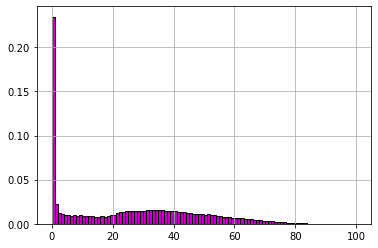

In [9]:
#plot the histogram of popularity before classifying to 11 bins
df_data['popularity'].hist(bins=100,facecolor = 'm',edgecolor = 'k' ,density = True)

In [10]:
#Classifying the popularity in 11 bins
df_data['popularity_class'] = np.ceil(df_data.popularity / 10)
df_data = df_data.drop(['popularity'], axis = 'columns')
df_da = df_data.drop(['popularity_class'], axis = 'columns')


Text(0.5, 1.0, 'popularity_class')

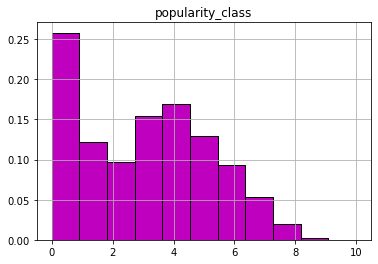

In [11]:
#plot the histogram of popularity after classifying to 11 bins
df_data['popularity_class'].hist(bins=11,facecolor = 'm',edgecolor = 'k' ,density = True )
plt.title('popularity_class')

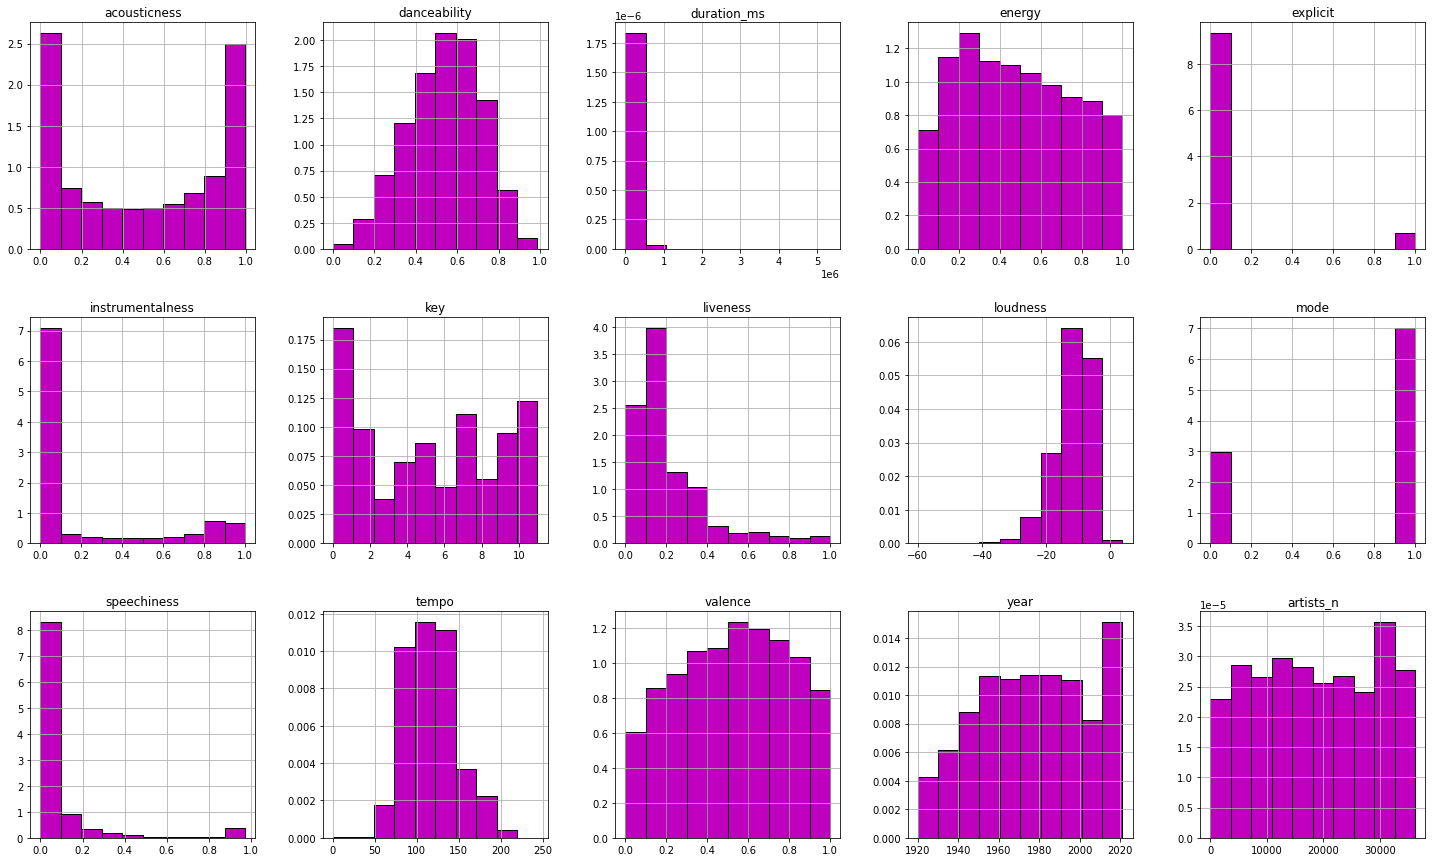

In [13]:
#Plot the histogram for each feature
df_da.hist(layout=(3,5),figsize=(25,15) ,facecolor = 'm',edgecolor = 'k' ,density = True);

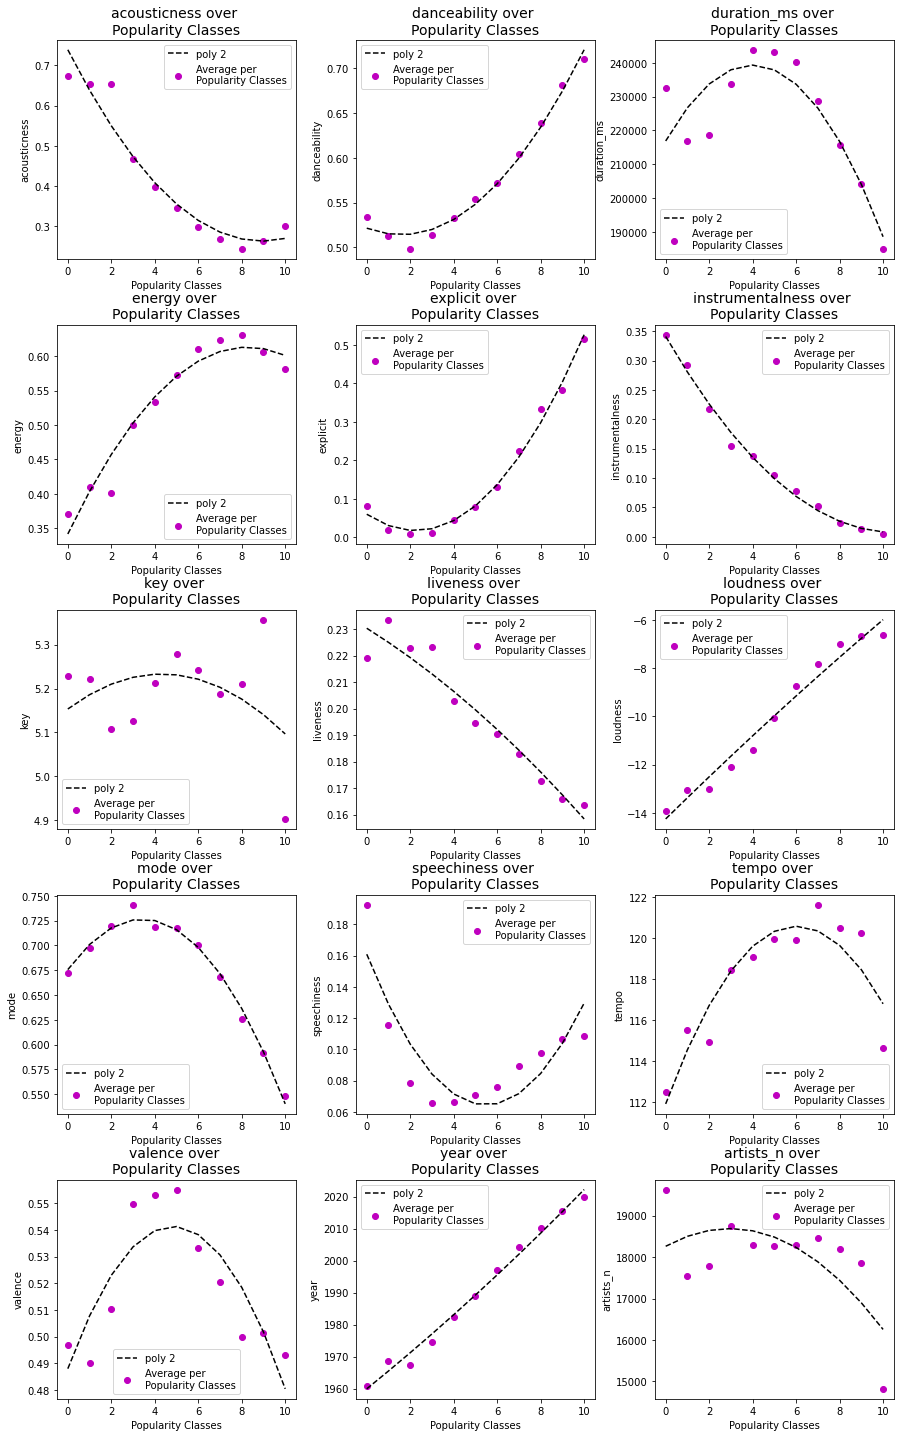

In [14]:
#Assess degree 2 polynimal of each feature for predicting popularity_class
groups = df_data.groupby(['popularity_class']).mean()
fig, axes1 = plt.subplots(5,3, figsize=(15, 25))
plt.subplots_adjust(hspace=0.3, wspace=0.25)


for row in axes1:
    for ax in row:
        col = groups.columns[list(axes1.flatten()).index(ax)]
        ax.scatter(groups.index, groups[col],color='m',label = 'Average per \nPopularity Classes')
        ax.plot(np.unique(groups.index), np.poly1d(np.polyfit(groups.index, groups[col], 2))(np.unique(groups.index)),
                'k--',label = 'poly 2')  #y = a+bx+cx^2    feature = a+ b(popularity) + c (popularity)^2
        ax.set_title(col + ' over \nPopularity Classes', size=14)
        ax.set_xlabel('Popularity Classes')
        ax.set_ylabel(col)
        ax.legend()
plt.show()

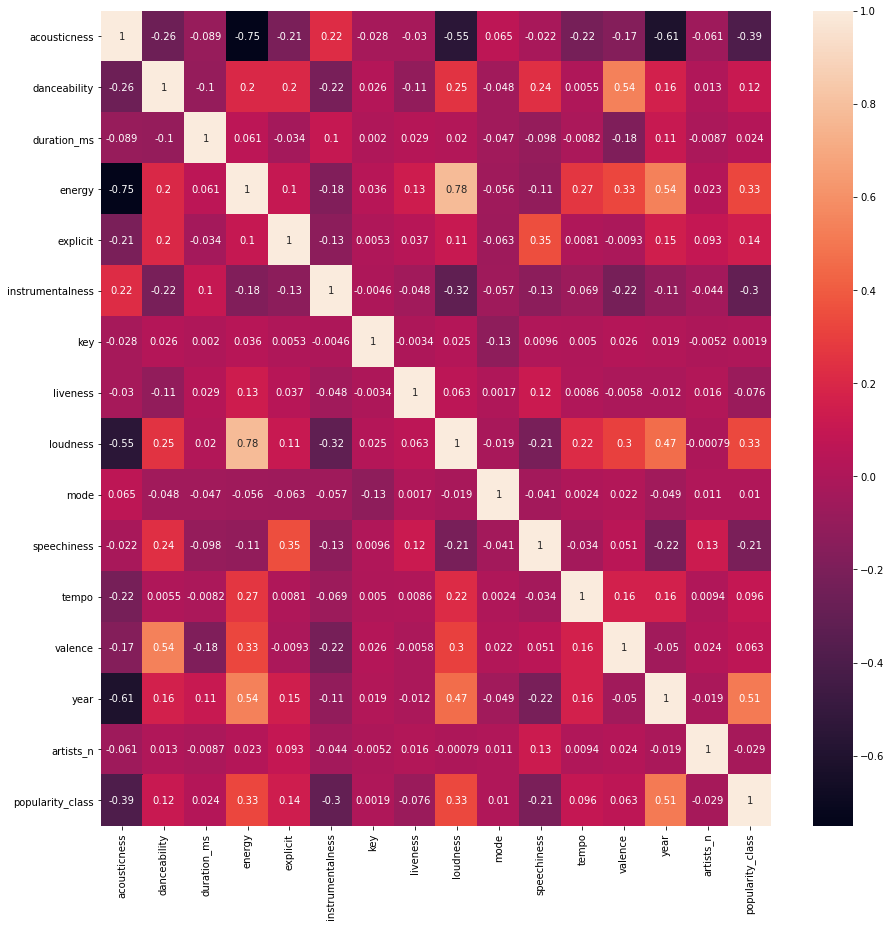

In [15]:
#The correlation among features are shown in heatmap
plt.figure(figsize=(15,15));
cor = df_data.corr();
sns.heatmap(cor, annot=True);
plt.show();

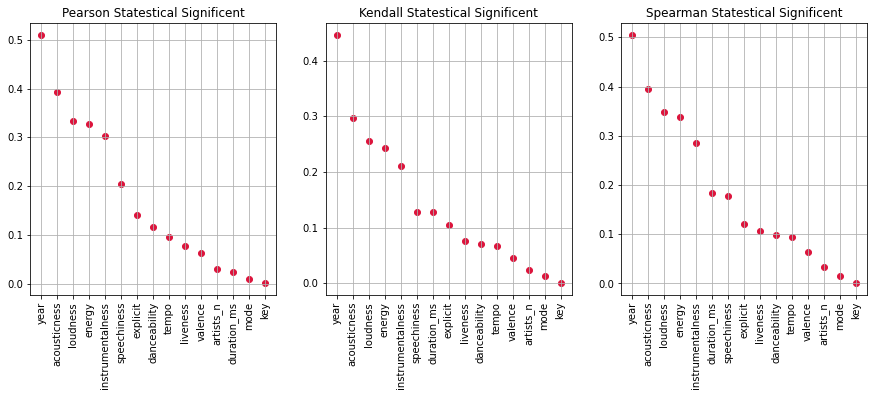

In [17]:
#Statistical significances
cor = df_data.corr(method='pearson'); # standard correlation 
cor_target = abs(cor["popularity_class"])
cork = df_data.corr(method='kendall');  # Tau correlation 
cor_targetk = abs(cork["popularity_class"])
cors = df_data.corr(method='spearman');  # rank correlation
cor_targets = abs(cors["popularity_class"])


plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(np.arange(1,16),cor_target.sort_values(ascending=False)[1:],color='crimson');
plt.xticks(np.arange(1,16),labels = cor_target.sort_values(ascending=False).index[1:], rotation=90);
plt.title('Pearson Statestical Significent');plt.grid()
plt.subplot(132)
plt.scatter(np.arange(1,16),cor_targetk.sort_values(ascending=False)[1:],color='crimson');
plt.xticks(np.arange(1,16),labels = cor_targetk.sort_values(ascending=False).index[1:], rotation=90);
plt.title('Kendall Statestical Significent');plt.grid()
plt.subplot(133)
plt.grid();
plt.scatter(np.arange(1,16),cor_targets.sort_values(ascending=False)[1:],color='crimson');
plt.xticks(np.arange(1,16),labels = cor_targets.sort_values(ascending=False).index[1:], rotation=90);
plt.title('Spearman Statestical Significent');

In [17]:
#cor_target.sort_values(ascending=False)[2:]  # first 2 belongs to popularity and popularity class
#cor_targets.sort_values(ascending=False)[2:]
#cor_targetk.sort_values(ascending=False)[2:]

In [18]:
###MinMax scaling

# datas = MinMaxScaler().fit_transform(df_data)

# df_datas = pd.DataFrame (datas, columns = df_data.columns)

# df_train, df_test = train_test_split(df_data, test_size = 0.3, random_state = 20210319)


# x_tr = df_train.drop(['popularity','popularity_class'], axis='columns')
# x_trains = MinMaxScaler().fit_transform(x_tr)
# x_train = pd.DataFrame (x_trains, columns = x_tr.columns)

# y_train = df_train['popularity_class']

# x_te = df_test.drop(['popularity','popularity_class'], axis='columns')
# x_tests = MinMaxScaler().fit_transform(x_te)
# x_test = pd.DataFrame (x_tests, columns = x_te.columns)

# y_test = df_test['popularity_class']


# print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

In [17]:
#Split the dataset into train and test set
df_train, df_test = train_test_split(df_data, test_size = 0.3, random_state = 20210319)


x_train = df_train.drop(['popularity_class'], axis='columns')
y_train = df_train['popularity_class']

x_test = df_test.drop(['popularity_class'], axis='columns')
y_test = df_test['popularity_class']


print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(122072, 15) (122072,) (52317, 15) (52317,)


In [17]:
#Implementing base XGBoost classifier
XGB_popularity = XGBClassifier(max_depth=3,               # Depth of each tree
                            learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=100,             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='multi:softmax',    # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=2,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=1,                  # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit. alpha = 0, lambda = 1 is Ridge.
                            random_state=20210319,        # Seed
                            min_child_weight = 1,
                            num_classes=11
                            )

In [18]:
#Defining hyperparametrs in dictionary
param_grid = dict({'n_estimators': [ 750, 1000],  # How many trees to use
                   'max_depth': [2,3,4],
                   'learning_rate' : [0.075, 0.1],        
                   'gamma': [0.0001,0.001],  # Minimum loss reduction required to make a further partition on a leaf node of the tree.
                   'colsample_bytree':[0.7,0.8]})  # Subsample ratio of columns when constructing each tree.

In [18]:
# Always a good idea to tune on a reduce sample of the train set, as we will call many functions.
val_train = df_train.sample(frac = 0.3,               # The fraction to extract
                           random_state = 20210319    # The seed.
                           )

x_val_train = df_test.drop(['popularity_class'], axis='columns')
y_val_train = df_test['popularity_class']

print(x_val_train.shape, y_val_train.shape)

(52317, 15) (52317,)


In [20]:
#Performing GridSearch for obtaining optimal parametrs
GridXGB = GridSearchCV(XGB_popularity,         # Original XGB. 
                       param_grid,             # Parameter grid
                       cv = 3,                 # Number of cross-validation folds.  
                       scoring = 'f1_macro',   # How to rank outputs.
                       n_jobs = 4,             # Parallel jobs. -1 is "all you have"
                       refit = False,          # If refit at the end with the best. We'll do it manually.
                       verbose = 1             # If to show what it is doing.
                       )

In [21]:
GridXGB.fit(x_val_train, y_val_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 39.7min
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed: 144.3min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None, colsample_bytree=1,
                                     gamma=0.001, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=2, nu...
                                     objective='multi:softmax',
                                     random_state=20210319, reg_alpha=1,
                                     reg_lambda=0, scale_pos_weight=None,
                                     subsample=1, tree_method=None,
   

In [22]:
# Show best params
GridXGB.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0.0001,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 1000}

In [23]:
#Create XGB with best parameters
XGB_popularity_b = XGBClassifier(max_depth=GridXGB.best_params_.get('max_depth'),             
                            learning_rate=GridXGB.best_params_.get('learning_rate'),         
                            n_estimators=GridXGB.best_params_.get('n_estimators'),             
                            verbosity=1,                  
                            objective='multi:softmax',   
                            booster='gbtree',            
                            n_jobs=2,                    
                            gamma=GridXGB.best_params_.get('gamma'),                  
                            subsample= 1,                  
                            colsample_bytree=GridXGB.best_params_.get('colsample_bytree'),           
                            reg_alpha=1,                  
                            reg_lambda=0,                 
                            random_state=20210319,        
                            min_child_weight = 1,
                            num_classes=11
                            )
# Train over all training data.
XGB_popularity_b.fit(x_train, y_train)

C:\Users\Maryam\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:10:30] WARNING: ..\src\learner.cc:541: 
Parameters: { num_classes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:10:30] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.0001, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=2, num_classes=11, num_parallel_tree=1,
              objective='multi:softprob', random_state=20210319, reg_alpha=1,
              reg_lambda=0, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

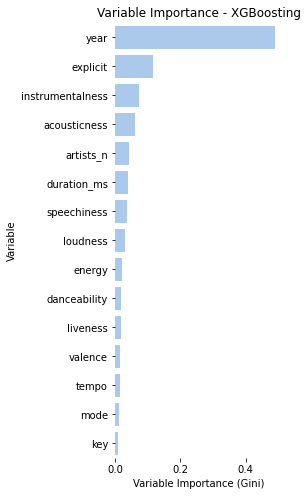

In [24]:
# Plot variable importance
importances = XGB_popularity_b.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[x_train.columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)

In [25]:
XGB_pred_class_test = XGB_popularity_b.predict(x_test)
XGB_pred_class_train = XGB_popularity_b.predict(x_train)

In [26]:
#Calculating f1 scores over test and training set for XGBoost classifier
test_f1_score_micro_XGB = f1_score(y_test, XGB_pred_class_test, average='micro')
train_f1_score_micro_XGB = f1_score(y_train, XGB_pred_class_train, average='micro')
print('test_f1_score_micro_XGB: ',test_f1_score_micro_XGB.round(3))
print('train_f1_score_micro_XGB: ',train_f1_score_micro_XGB.round(3))
test_f1_score_macro_XGB = f1_score(y_test, XGB_pred_class_test, average='macro')
train_f1_score_macro_XGB = f1_score(y_train, XGB_pred_class_train, average='macro')
print('test_f1_score_macro_XGB: ',test_f1_score_macro_XGB.round(3))
print('train_f1_score_macro_XGB: ',train_f1_score_macro_XGB.round(3))
test_f1_score_XGB = f1_score(y_test, XGB_pred_class_test, average=None)
train_f1_score_XGB = f1_score(y_train, XGB_pred_class_train, average=None)
print('test_f1_score_XGB: ',test_f1_score_XGB.round(3))
print('train_f1_score_XGB: ',train_f1_score_XGB.round(3))

test_f1_score_micro_XGB:  0.531
train_f1_score_micro_XGB:  0.581
test_f1_score_macro_XGB:  0.384
train_f1_score_macro_XGB:  0.572
test_f1_score_XGB:  [0.838 0.504 0.493 0.472 0.432 0.299 0.376 0.301 0.299 0.076 0.133]
train_f1_score_XGB:  [0.854 0.56  0.523 0.523 0.501 0.384 0.426 0.4   0.467 0.702 0.952]


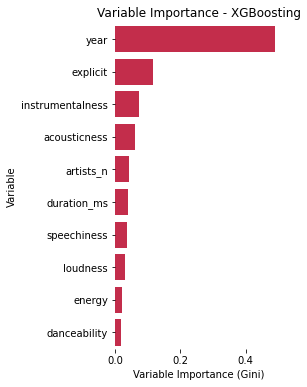

In [27]:
#Plot important features in XGBoosting
importances = XGB_popularity_b.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 6))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[x_train.columns[i] for i in indices[0:10]], x=importances[indices[0:10]], 
            label="Total", color="crimson")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)
plt.savefig('importantf.png')

In [19]:
#Implementing base RandomForest classifier
RF_popularity = RandomForestClassifier(n_estimators=1000, # Number of trees to train
                       criterion='gini', # How to train the trees. Also supports entropy.
                       max_depth=None, # Max depth of the trees. Not necessary to change.
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features='auto', # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       n_jobs=4, # Parallel processing. None = 1 core Set to -1 for all cores. Watch your RAM!!
                       random_state=20210319, # Seed
                       verbose=1 # If to give info during training. Set to 0 for silent training.
                       )

In [20]:
#Defining hyperparametrs in dictionary
RF_grid = dict({'n_estimators': [ 750, 1000, 1250],  
               'min_impurity_decrease' :  [0.00001,0.0001],
               'min_samples_split' : [2, 10, 50],
               'min_samples_leaf':[0.0001,0.001]})

In [21]:
#conducting GridSearch for obtaining best parametrs
GridRF = GridSearchCV(RF_popularity,         # Original XGB. 
                       RF_grid,             # Parameter grid
                       cv = 3,                 # Number of cross-validation folds.  
                       scoring = 'f1_macro',   # How to rank outputs.
                       n_jobs = 4,             # Parallel jobs. -1 is "all you have"
                       refit = False,          # If refit at the end with the best. We'll do it manually.
                       verbose = 1             # If to show what it is doing.
                       )

In [22]:
GridRF.fit(x_val_train, y_val_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 11.9min
[Parallel(n_jobs=4)]: Done 108 out of 108 | elapsed: 27.5min finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(min_impurity_decrease=0.0001,
                                              min_samples_leaf=0.001,
                                              n_estimators=1000, n_jobs=4,
                                              random_state=20210319,
                                              verbose=1),
             n_jobs=4,
             param_grid={'min_impurity_decrease': [1e-05, 0.0001],
                         'min_samples_leaf': [0.0001, 0.001],
                         'min_samples_split': [2, 10, 50],
                         'n_estimators': [750, 1000, 1250]},
             refit=False, scoring='f1_macro', verbose=1)

In [23]:
# Show best params
GridRF.best_params_

{'min_impurity_decrease': 1e-05,
 'min_samples_leaf': 0.0001,
 'min_samples_split': 10,
 'n_estimators': 1250}

In [24]:
#Construct RandomForest with best parameters
RF_popularity_b = RandomForestClassifier(n_estimators=GridRF.best_params_.get('n_estimators'),
                       criterion='gini', 
                       max_depth=None, 
                       min_samples_split=GridRF.best_params_.get('min_samples_split'),
                       min_samples_leaf=GridRF.best_params_.get('min_samples_leaf'), 
                       min_weight_fraction_leaf=0.0, 
                       max_features='auto', 
                       max_leaf_nodes=None, 
                       min_impurity_decrease=GridRF.best_params_.get('min_impurity_decrease'), 
                       n_jobs=4, 
                       random_state=20210319, 
                       verbose=1)
# Train over all training data.
RF_popularity_b.fit(x_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   30.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   58.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 1250 out of 1250 | elapsed:  1.6min finished


RandomForestClassifier(min_impurity_decrease=1e-05, min_samples_leaf=0.0001,
                       min_samples_split=10, n_estimators=1250, n_jobs=4,
                       random_state=20210319, verbose=1)

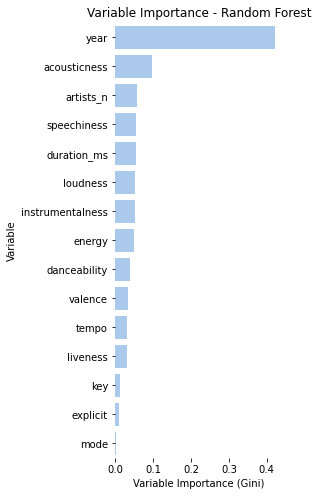

In [25]:
# Plot order of important features for RandomForest classifier
importances = RF_popularity_b.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - Random Forest")
sns.set_color_codes("pastel")
sns.barplot(y=[x_train.columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)

In [26]:
RF_pred_class_test = RF_popularity_b.predict(x_test)
RF_pred_class_train = RF_popularity_b.predict(x_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 1250 out of 1250 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    9.4s
[Parallel(n_jobs=4)]: Done 1250 out of 1250 | elapsed:    9.5s finished


In [27]:
#Evaluate the performance of model through F1 score over test and training set
test_f1_score_micro_RF = f1_score(y_test, RF_pred_class_test, average='micro')
train_f1_score_micro_RF = f1_score(y_train, RF_pred_class_train, average='micro')
print('test_f1_score_micro_RF: ',test_f1_score_micro_RF.round(3))
print('train_f1_score_micro_RF: ',train_f1_score_micro_RF.round(3))
test_f1_score_macro_RF = f1_score(y_test, RF_pred_class_test, average='macro')
train_f1_score_macro_RF = f1_score(y_train, RF_pred_class_train, average='macro')
print('test_f1_score_macro_RF: ',test_f1_score_macro_RF.round(3))
print('train_f1_score_macro_RF: ',train_f1_score_macro_RF.round(3))
test_f1_score_RF = f1_score(y_test, RF_pred_class_test, average=None)
train_f1_score_RF = f1_score(y_train, RF_pred_class_train, average=None)
print('test_f1_score_RF: ',test_f1_score_RF.round(3))
print('train_f1_score_RF: ',train_f1_score_RF.round(3))

test_f1_score_micro_RF:  0.517
train_f1_score_micro_RF:  0.688
test_f1_score_macro_RF:  0.343
train_f1_score_macro_RF:  0.497
test_f1_score_RF:  [0.814 0.426 0.484 0.45  0.439 0.277 0.364 0.299 0.215 0.    0.   ]
train_f1_score_RF:  [0.854 0.593 0.582 0.713 0.727 0.598 0.495 0.47  0.434 0.    0.   ]


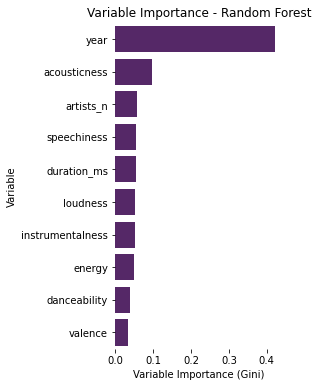

In [30]:
#Show the 10 most important features
importances = RF_popularity_b.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 6))
plt.title("Variable Importance - Random Forest")
sns.set_color_codes("dark")

sns.barplot(y=[x_train.columns[i] for i in indices[0:10]], x=importances[indices[0:10]], 
            label="Total", color="m")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)
plt.savefig('importantf.png')